# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os

from openpyxl.styles.builtins import title

data_folder = os.path.join('../data/interim')

In [2]:
# Load the data of patient 1 and patient 2

# load the data, set the first column as index, parse the index as datetime
p01 = pd.read_csv(os.path.join(data_folder, 'p01_train.csv'), index_col=0)
p01.index = pd.to_datetime(p01.index)
p01['week'] = p01['days_since_start'] // 7

p02 = pd.read_csv(os.path.join(data_folder, 'p02_train.csv'), index_col=0)
p02.index = pd.to_datetime(p02.index)
p02['week'] = p02['days_since_start'] // 7

all_data = pd.read_csv(os.path.join(data_folder, 'all_train.csv'), index_col=0)
all_data.index = pd.to_datetime(all_data.index)
all_data['week'] = all_data['days_since_start'] // 7

In [3]:
p01.head()

,p_num,days_since_start,time,initial_resolution,bg,insulin,carbs,hr,steps,cals,activity,bg+1:00,week
2020-01-01 00:15:00,p01,0,00:15:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:20:00,p01,0,00:20:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:25:00,p01,0,00:25:00,15min,9.6,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:30:00,p01,0,00:30:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:35:00,p01,0,00:35:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
all_data.head()

,p_num,days_since_start,time,initial_resolution,bg,insulin,carbs,hr,steps,cals,activity,bg+1:00,week
2020-01-01 00:15:00,p01,0,00:15:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:20:00,p01,0,00:20:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:25:00,p01,0,00:25:00,15min,9.6,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:30:00,p01,0,00:30:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-01 00:35:00,p01,0,00:35:00,15min,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,0


# Daily Blood Glucose Level, Calories, Carbs, Insulin and Heart Rate for different patients on different days
 

In [5]:
def plot(patient_id: str, start_day: int, end_day: int | None = None):
    end_day = start_day if end_day is None else end_day

    patient = all_data[all_data.p_num == patient_id]
    patient_range = patient[(patient.days_since_start >= start_day) & (patient.days_since_start <= end_day)]

    # fill missing values with linear interpolation
    patient_range_bg = patient_range['bg']
    patient_range_bg = patient_range_bg.interpolate(method='linear')

    # normalize the carbs to be between 0 and 1, fill missing values with 0
    patient_range_carbs = patient_range['carbs']
    patient_range_carbs = patient_range_carbs.fillna(0)
    patient_range_carbs = (patient_range_carbs - patient_range_carbs.min()) / (patient_range_carbs.max() - patient_range_carbs.min())

    # normalize the insulin to be between 0 and 1
    patient_range_insulin = patient_range['insulin']
    patient_range_insulin = patient_range_insulin.fillna(0)
    patient_range_insulin = (patient_range_insulin - patient_range_insulin.min()) / (patient_range_insulin.max() - patient_range_insulin.min())

    patient_range_cals = patient_range['cals']
    patient_range_cals = patient_range_cals.interpolate(method='linear')

    patient_range_heart_rate = patient_range['hr']
    patient_range_heart_rate = patient_range_heart_rate.interpolate(method='linear')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 8))
    title = f'Patient {patient_id} from day {start_day} to {end_day}' if end_day != start_day else f'Patient {patient_id} on day {start_day}' 
    fig.suptitle(title, fontsize=16, fontweight='bold', verticalalignment='baseline')

    ax1.plot(patient_range_bg.index, patient_range_bg, color='red', linestyle='-', linewidth=1, label='Blood Glucose')
    ax1.set_ylabel('Blood Glucose')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.tick_params(axis='x', rotation=45)
    max_bg = np.ceil(np.max(patient_range_bg))
    ax1.set_ylim(bottom=0, top=max_bg)
    ax1.set_yticks(np.arange(0, max_bg, max_bg / 5))

    ax1_2 = ax1.twinx()
    ax1_2.plot(patient_range_carbs.index, patient_range_carbs, color='blue', linestyle='-', linewidth=1, label='Carbs')
    ax1_2.plot(patient_range_insulin.index, patient_range_insulin, color='green', linestyle='-', linewidth=1, markersize=6, label='Insulin')
    ax1_2.set_ylabel('Carbs/Insulin normalized')
    ax1_2.set_ylim(bottom=0, top=1)

    # Add legends for both line and bar plots
    ax1.legend(loc='upper left')
    ax1_2.legend(loc='upper right')

    ax2.plot(patient_range_cals.index, patient_range_cals, color='orange', linestyle='-', linewidth=1, markersize=6, label='Calories')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=0, top=60)
    ax2.set_yticks(np.arange(0, 60, 10))

    ax2_1 = ax2.twinx()
    ax2_1.plot(patient_range.index, patient_range_heart_rate, color='purple', linestyle='-', linewidth=1, markersize=6, label='Heart Rate')
    ax2_1.set_ylabel('Heart Rate')
    ax2_1.set_ylim(bottom=0, top=180)
    ax2_1.set_yticks(np.arange(0, 180, 30))

    ax2.legend(loc='upper left')
    ax2_1.legend(loc='upper right')

    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

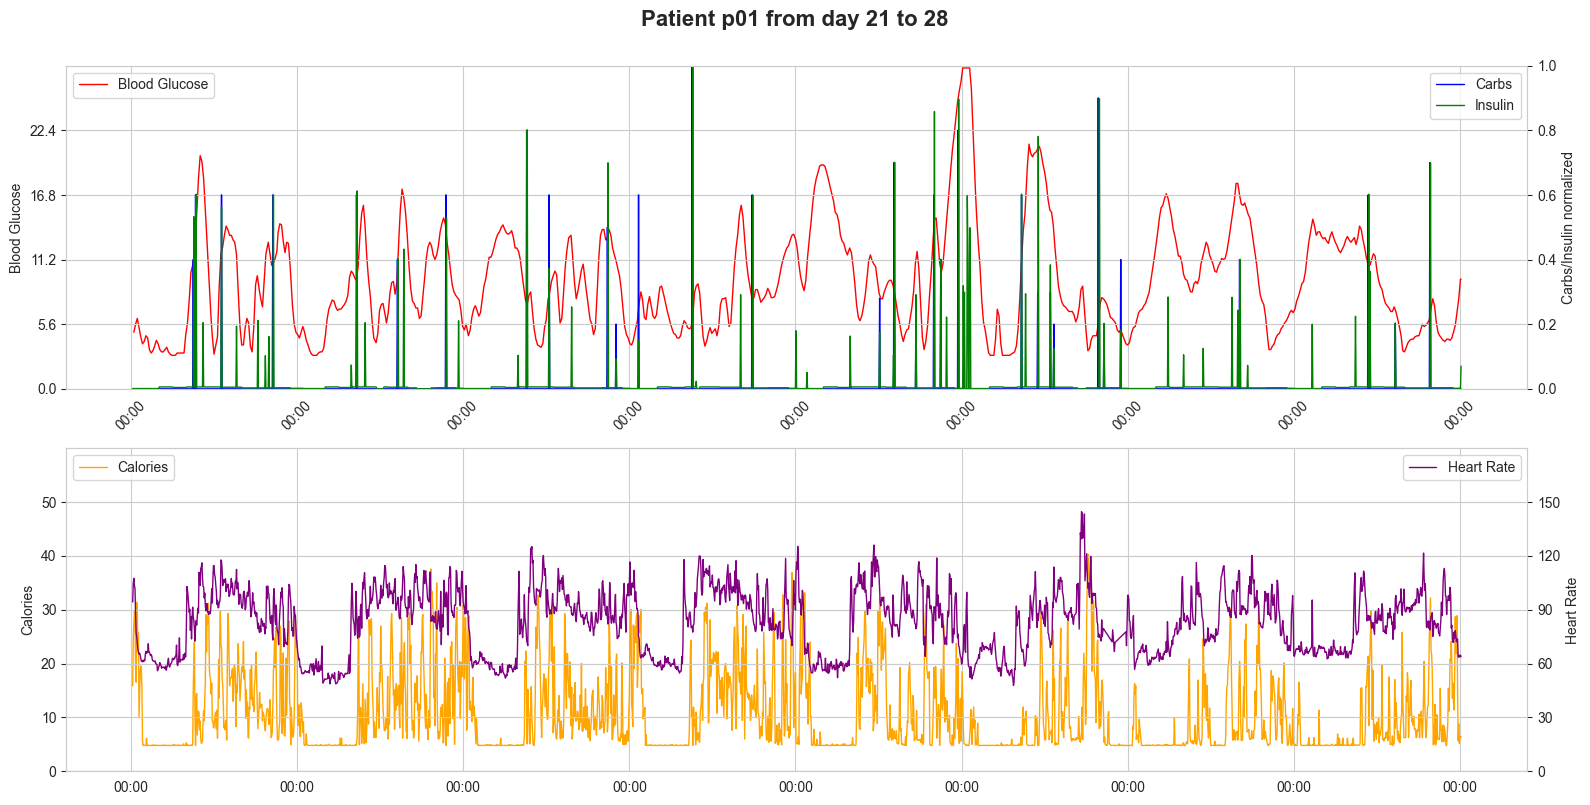

In [6]:
plot('p01', 21, 28)

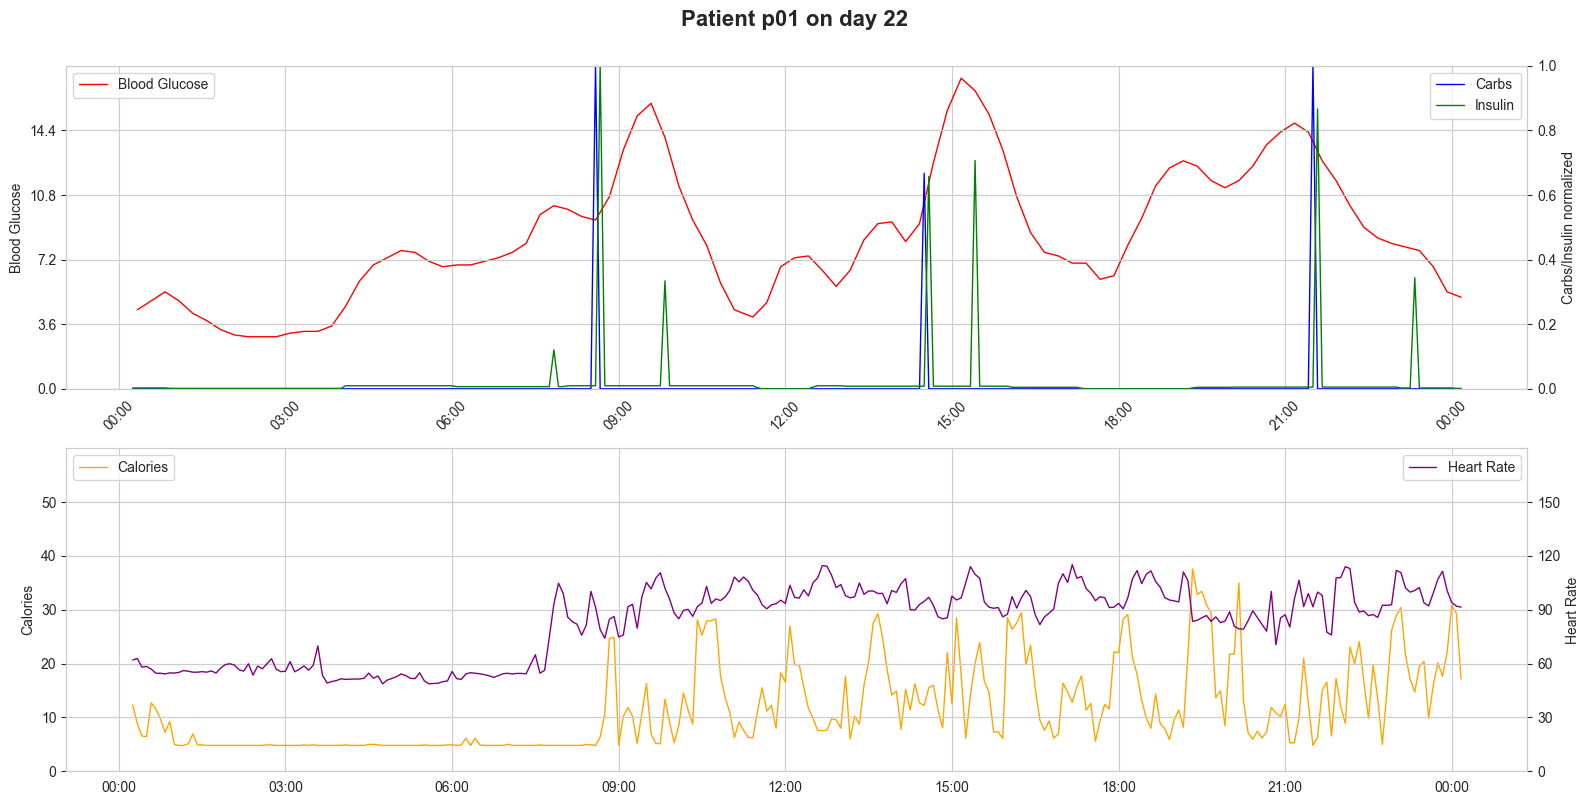

In [7]:
plot('p01',22, 22)

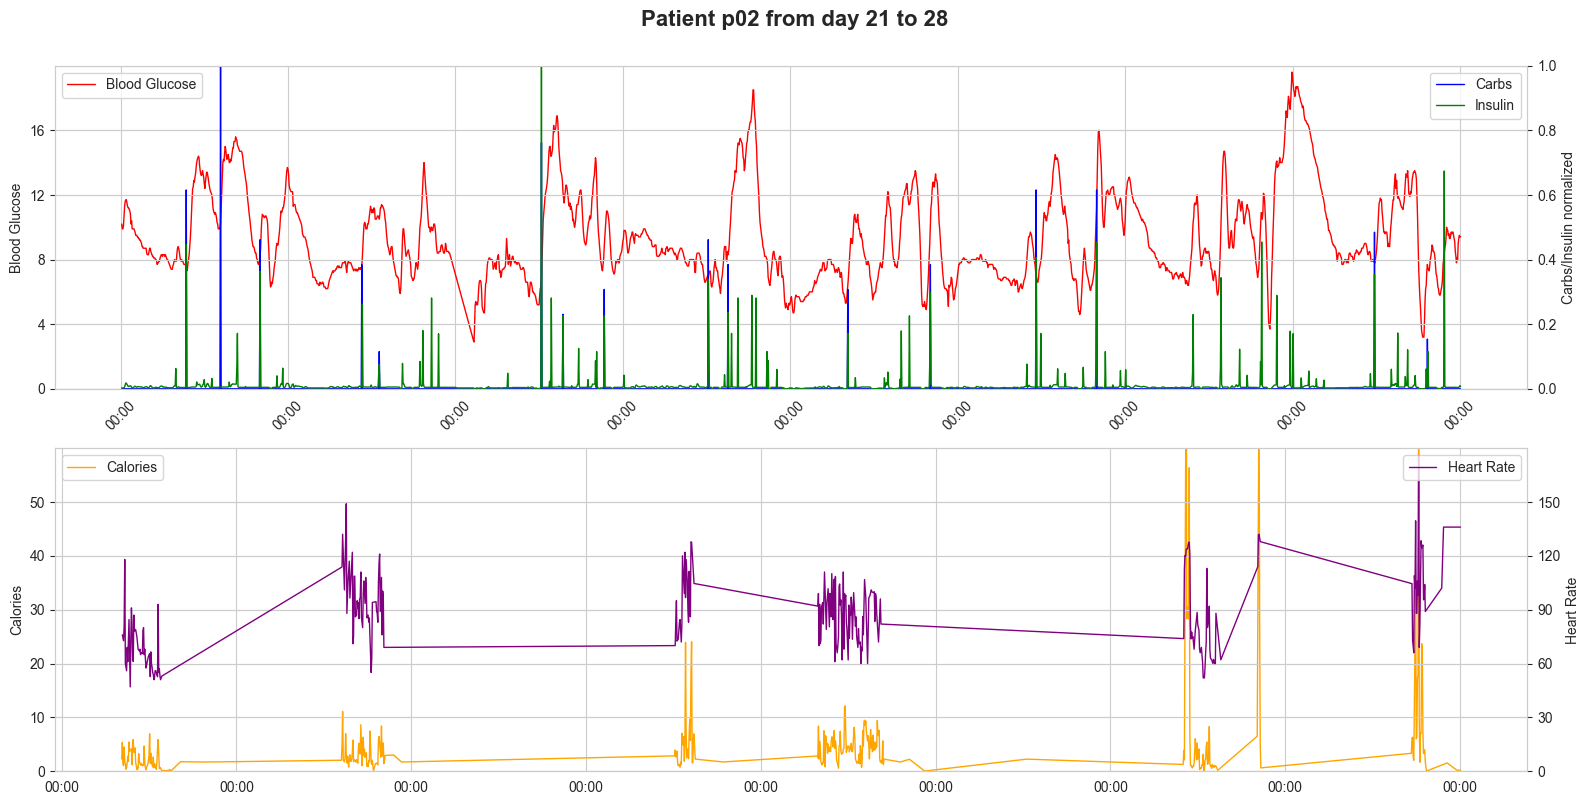

In [8]:
plot('p02', 21, 28)

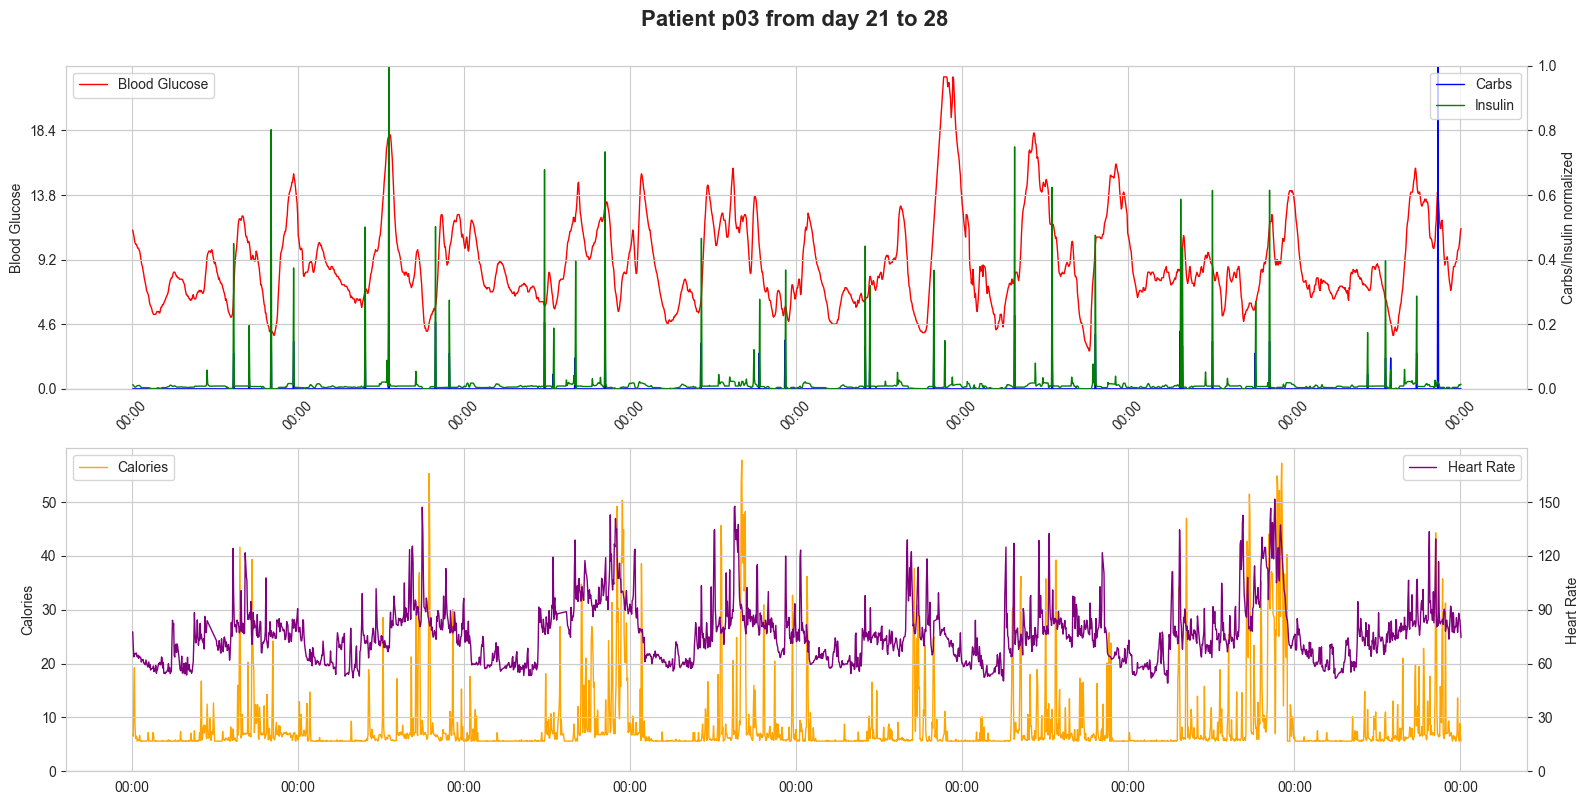

In [9]:
plot('p03', 21, 28)

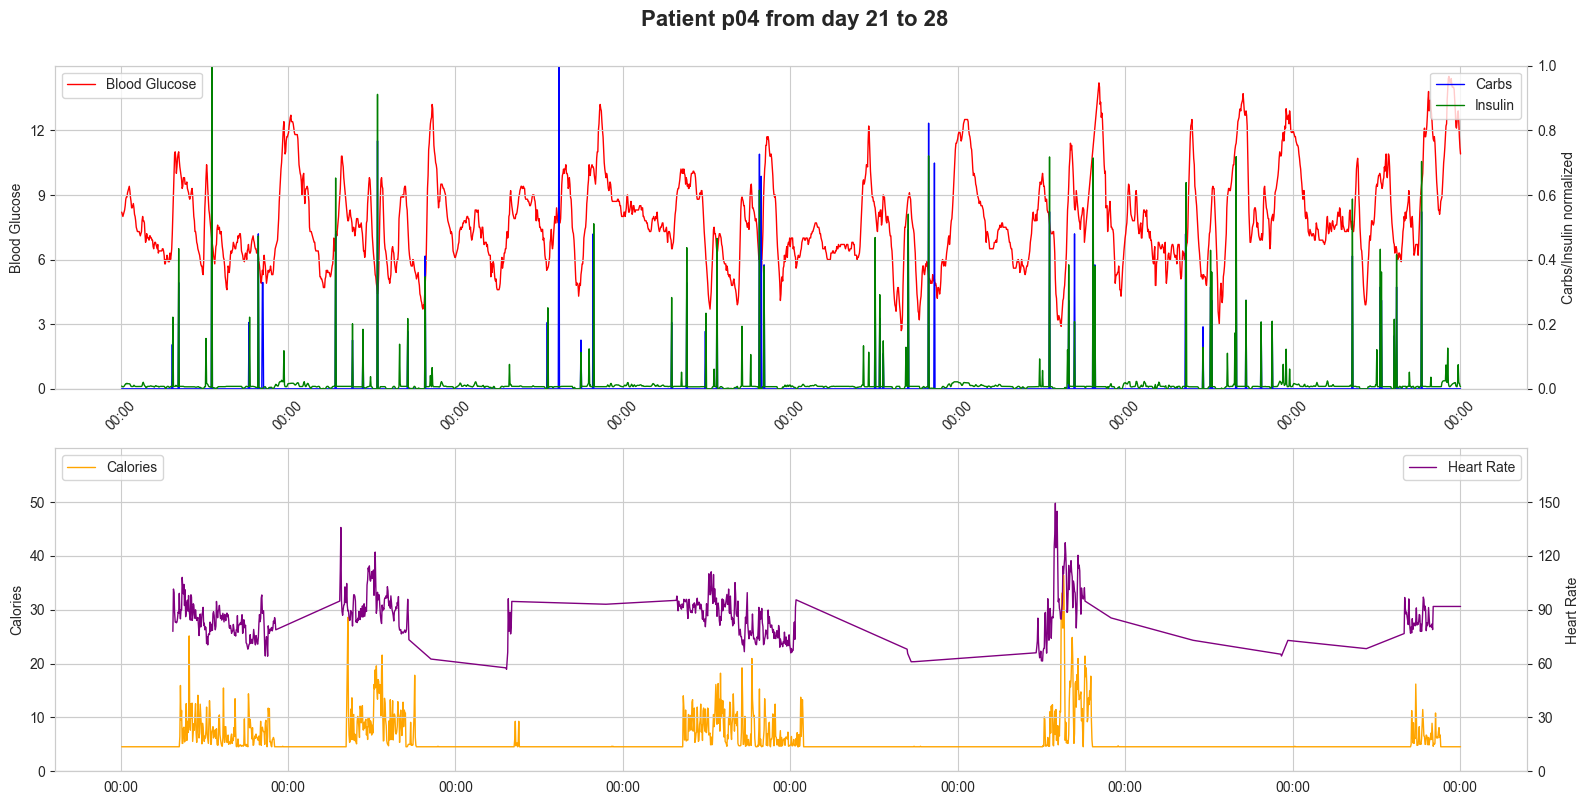

In [10]:
plot('p04', 21, 28)

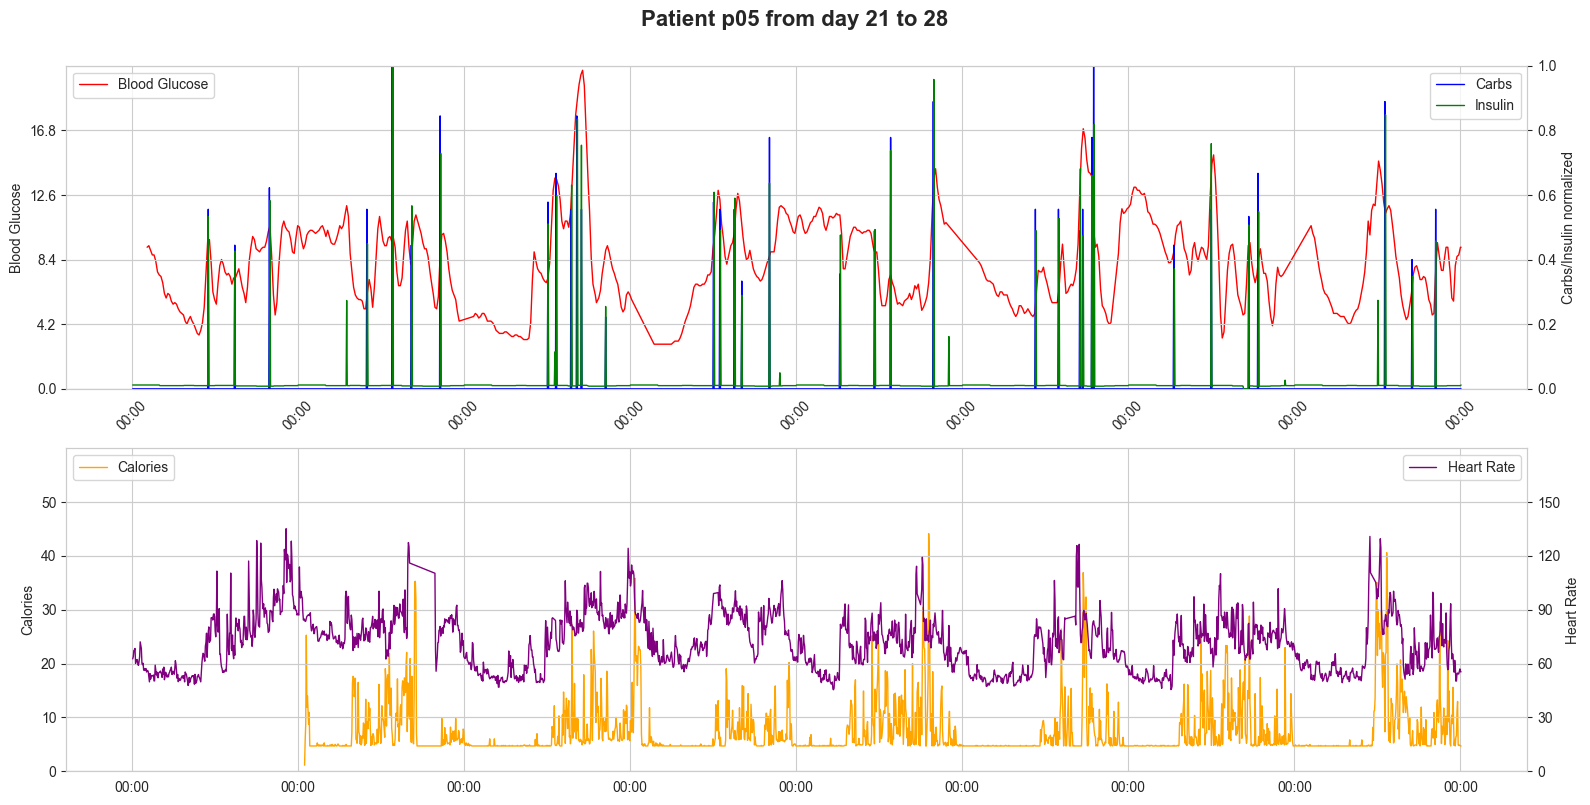

In [11]:
plot('p05', 21, 28)

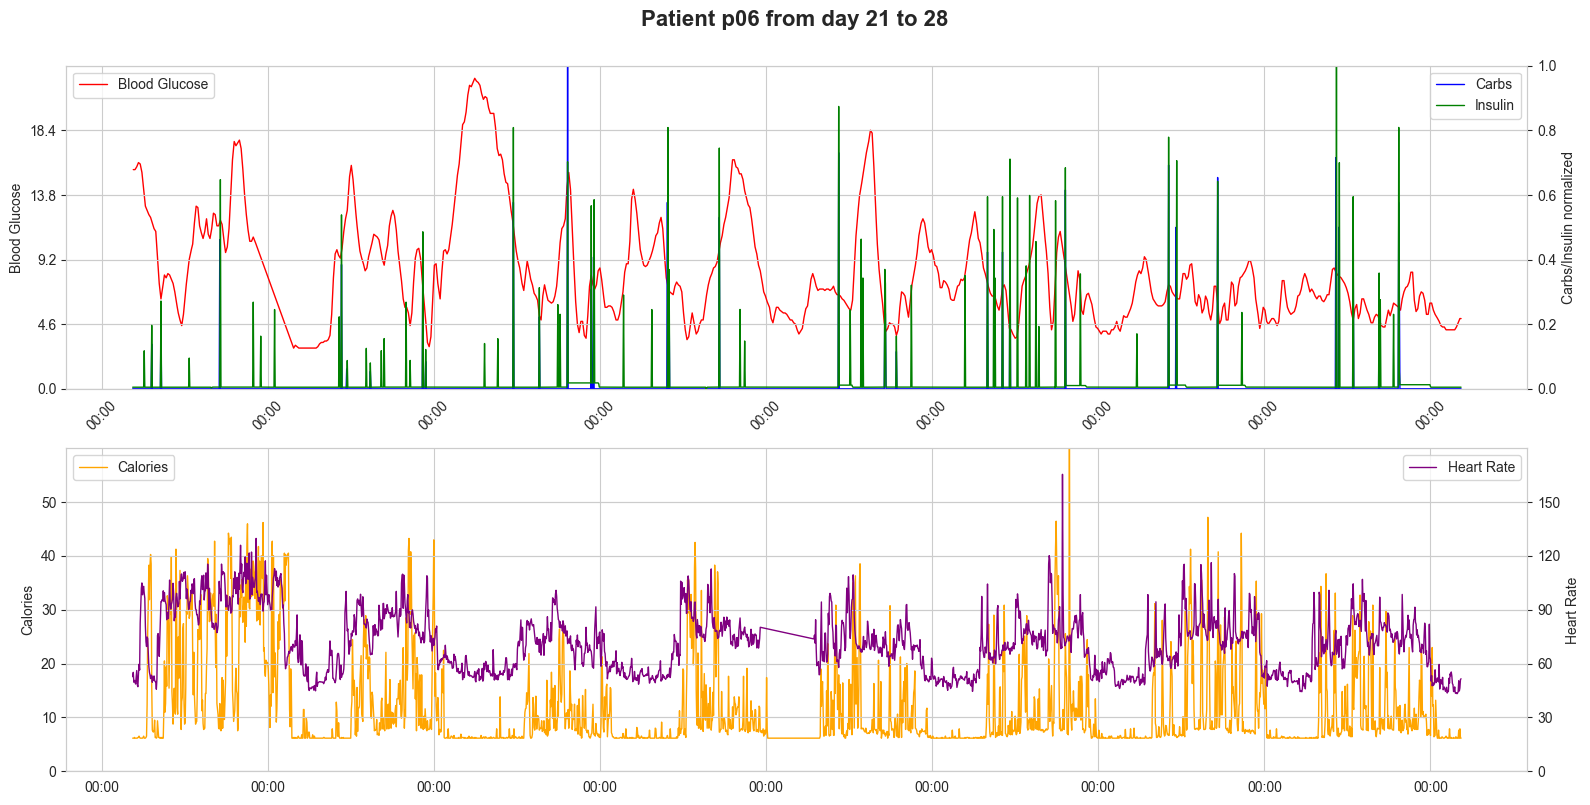

In [12]:
plot('p06', 21, 28)

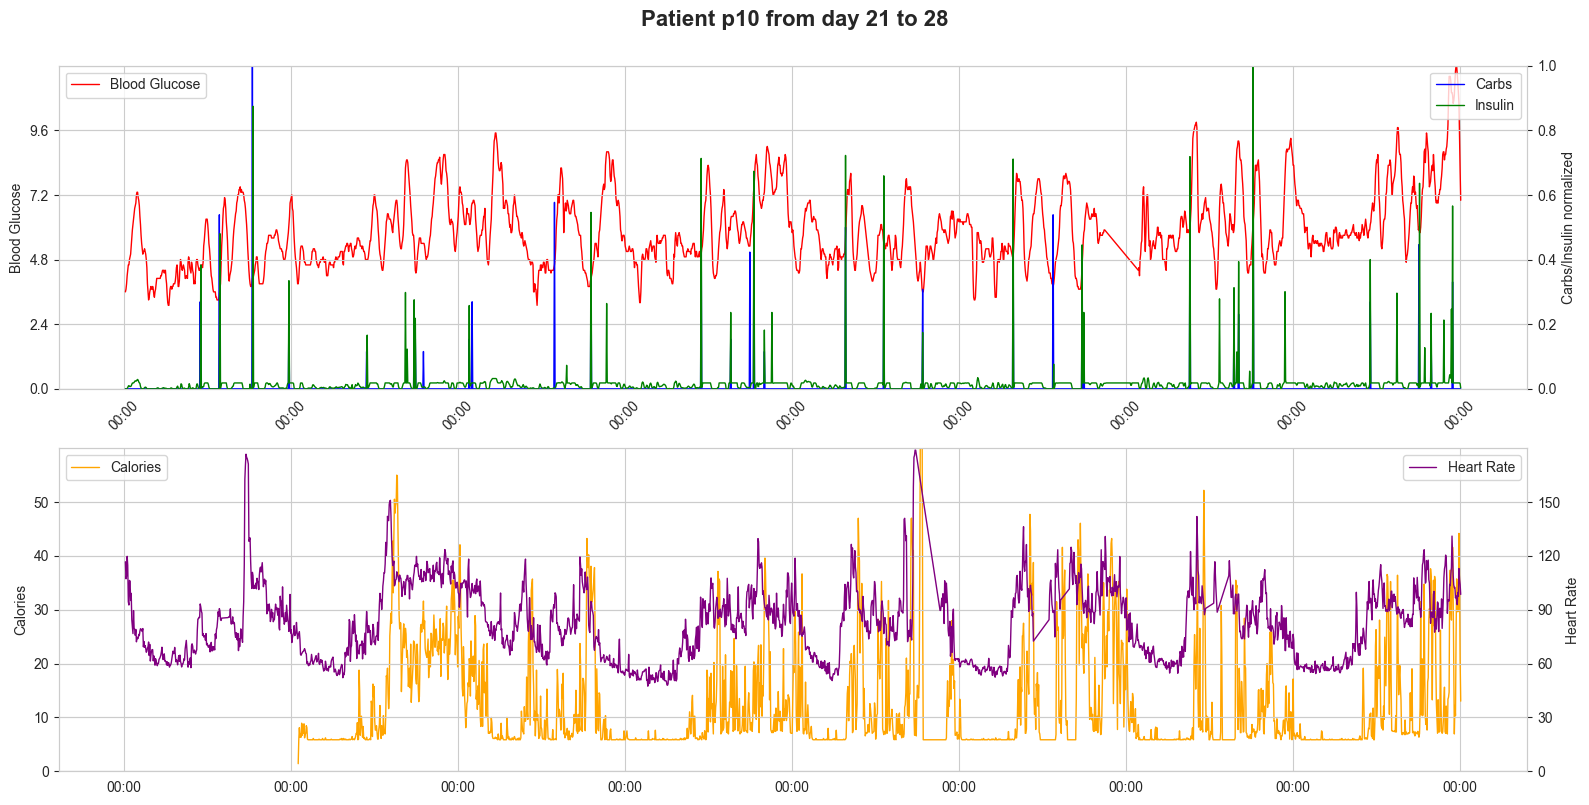

In [13]:
plot('p10', 21, 28)

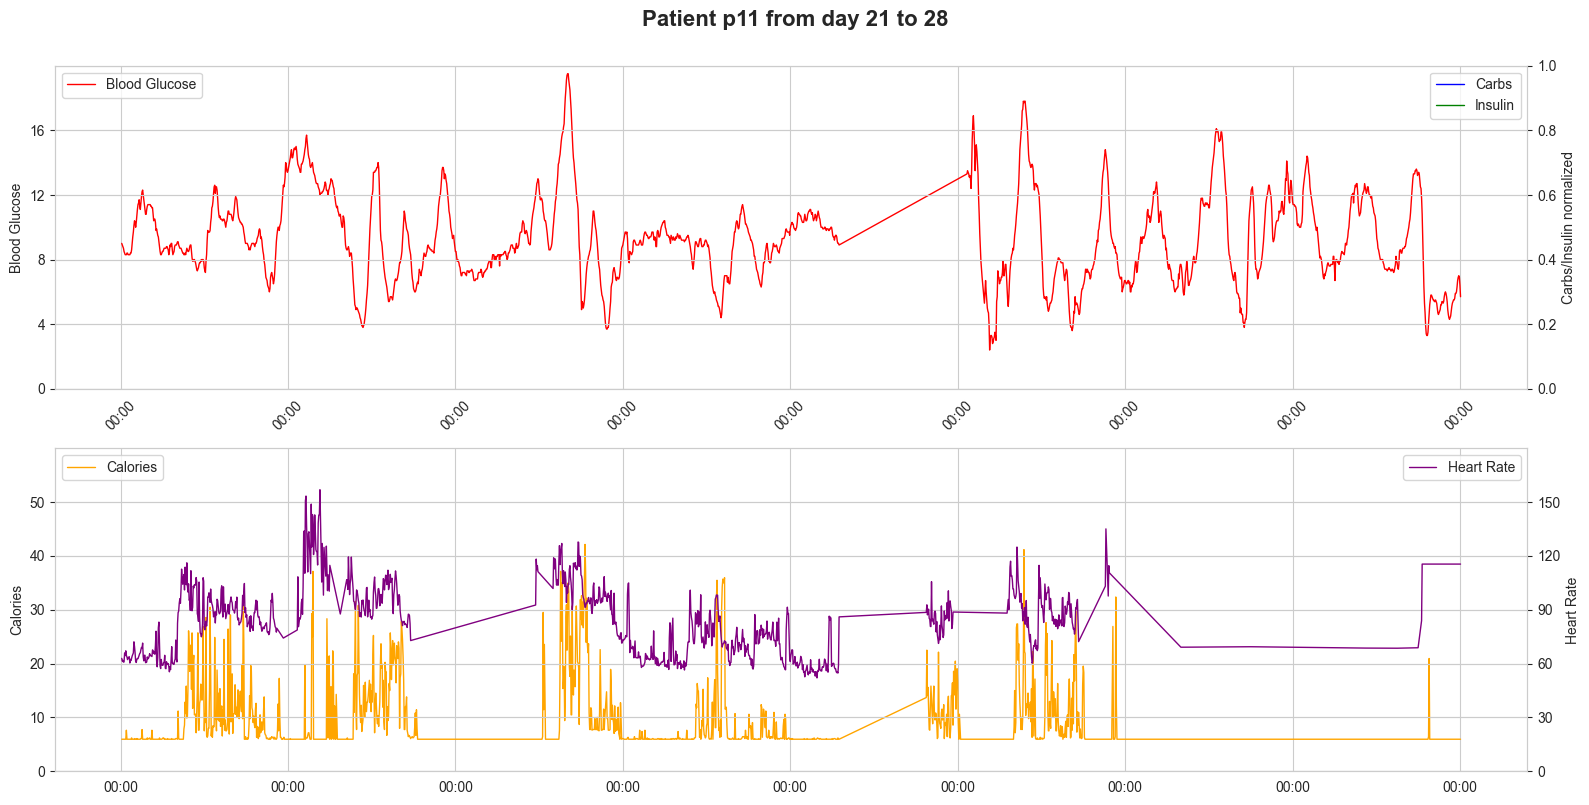

In [14]:
plot('p11', 21, 28)

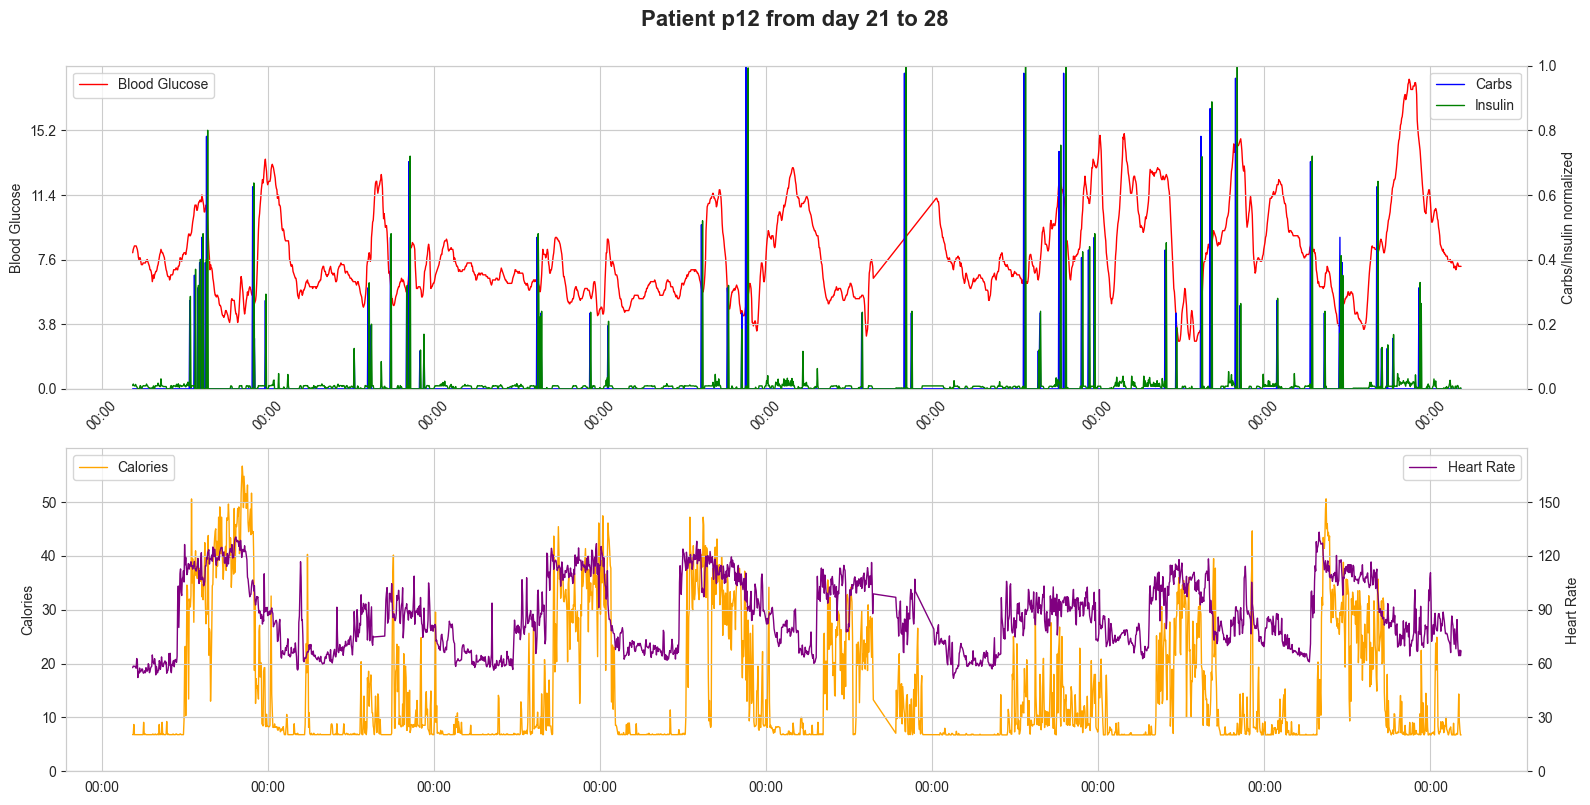

In [15]:
plot('p12', 21, 28)